In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import sys

sys.path.append('../guided-diffusion')

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Jun  3 17:24:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:19:00.0 Off |                  Off |
| 37%   69C    P2            382W /  450W |    7953MiB /  24564MiB |     99%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

import numpy as np
import torch as th

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    add_dict_to_argparser,
    args_to_dict,
)

### Hyper-parameters

In [4]:
from easydict import EasyDict
defaults = EasyDict(
    clip_denoised=True,
    num_samples=10000,
    batch_size=64,
    use_ddim=False,
    model_path='models/64x64_diffusion.pt',
    classifier_path='models/64x64_classifier.pt',
)
defaults.update(model_and_diffusion_defaults())
defaults.update(classifier_defaults())

args = defaults
args.attention_resolutions = "32,16,8"
args.class_cond = True
args.diffusion_steps = 1000
args.dropout = 0.1 
args.image_size = 64 
args.learn_sigma = True 
args.noise_schedule = 'cosine'
args.num_channels = 192 
args.num_head_channels = 64 
args.num_res_blocks = 3 
args.resblock_updown = True
args.use_new_attention_order = True
args.use_fp16 = True
args.classifier_use_fp16 = True
args.classifier_depth = 4
args.use_scale_shift_norm = True
args.timestep_respacing = "250"
args.classifier_scale = 10.0

In [5]:
classifier_defaults()

{'image_size': 64,
 'classifier_use_fp16': False,
 'classifier_width': 128,
 'classifier_depth': 2,
 'classifier_attention_resolutions': '32,16,8',
 'classifier_use_scale_shift_norm': True,
 'classifier_resblock_updown': True,
 'classifier_pool': 'attention'}

### Model

In [6]:
device = 'cuda:0'
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
model = model.to(device)

checkpoint = th.load(args.model_path, map_location='cpu')
model.load_state_dict(checkpoint)
model.convert_to_fp16()
model.eval()

classifier = create_classifier(**args_to_dict(args, classifier_defaults().keys()))
classifier = classifier.to(device)
checkpoint = th.load(args.classifier_path, map_location='cpu')
classifier.load_state_dict(checkpoint)
classifier.convert_to_fp16()
classifier.eval()

print('done')

done


In [7]:
def get_denorm(x):
    x = ((x + 1) * 127.5).clamp(0, 255).to(th.uint8)
    x = x.permute(0, 2, 3, 1)
    x = x.contiguous()
    return x

In [8]:
def cond_fn(x, t, y=None):
    assert y is not None
    with th.enable_grad():
        x_in = x.detach().requires_grad_(True)
        logits = classifier(x_in, t)
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs[range(len(logits)), y.view(-1)]
        return th.autograd.grad(selected.sum(), x_in)[0] * args.classifier_scale

step :  249


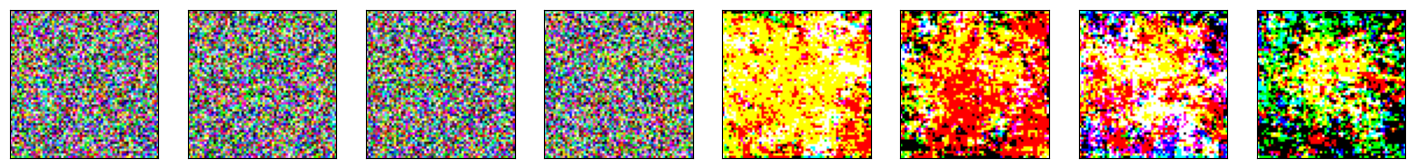

step :  200


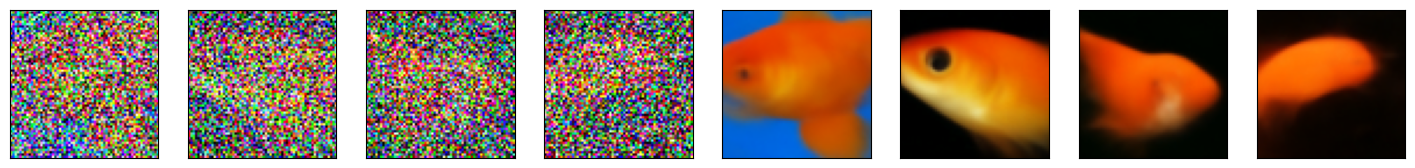

step :  150


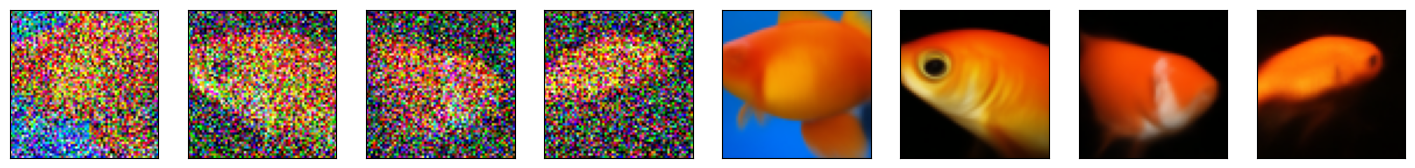

step :  100


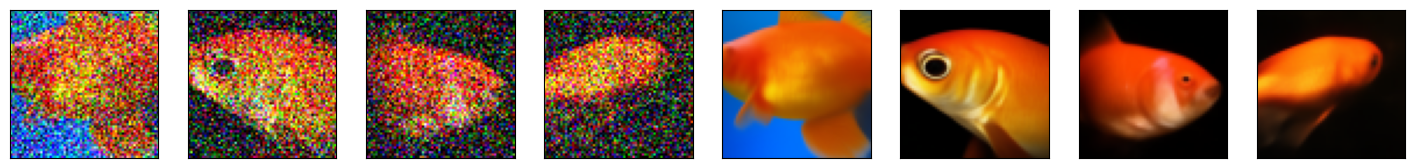

step :  50


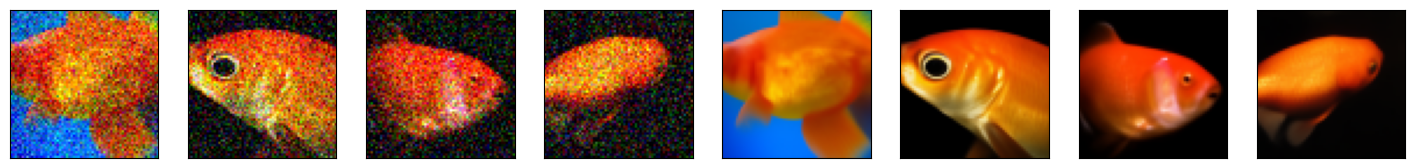

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

model_kwargs = {}
classes = torch.Tensor([1 for _ in range(args.batch_size)]).int().to(device)
model_kwargs["y"] = classes

shape = (args.batch_size, 3, args.image_size, args.image_size)
img = th.randn(*shape, device=device)
indices = list(range(diffusion.num_timesteps))[::-1]
for i in indices:
    t = torch.tensor([i] * shape[0], device=device)
    with th.no_grad():
        out = diffusion.p_sample(
            model,
            img,
            t,
            clip_denoised=args.clip_denoised,
            denoised_fn=None,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
        )
        img = out["sample"]
        img_pred_print = get_denorm(img)
        x0_pred = out['pred_xstart']
        x0_pred_print = get_denorm(x0_pred)
        
        if i % 50 == 0 or i == indices[0]:
            print('step : ', str(i))
            plt.figure(figsize=[18, 3])
            for i in range(4):
                plt.subplot(1, 8, i+1)
                plt.imshow(img_pred_print[i].data.cpu().numpy())
                plt.xticks([])
                plt.yticks([])
                plt.subplot(1, 8, i+1+4)
                plt.imshow(x0_pred_print[i].data.cpu().numpy())
                plt.xticks([])
                plt.yticks([])
            plt.show()

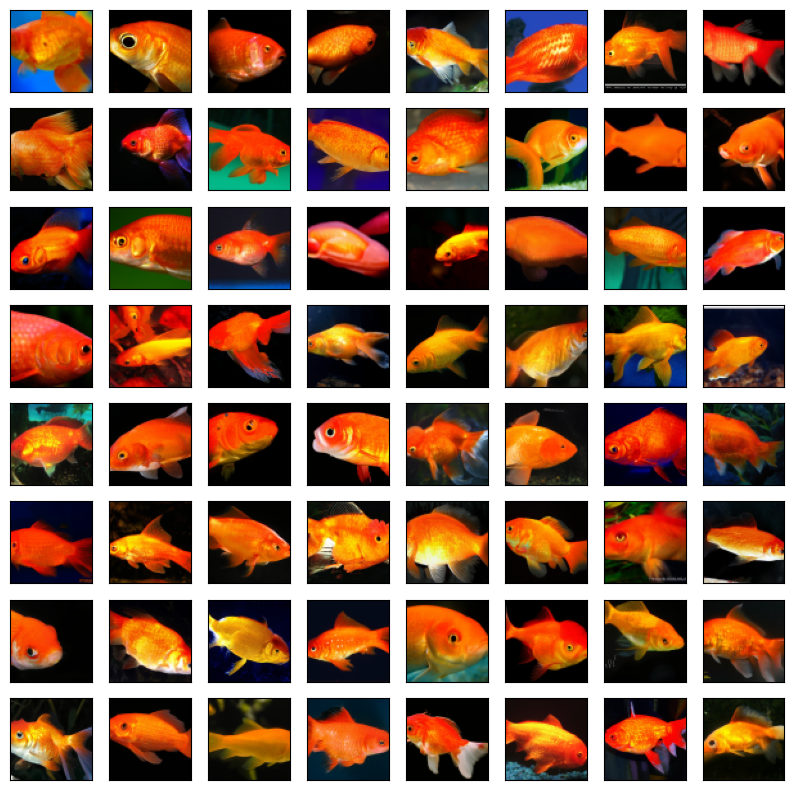

In [13]:
import matplotlib.pyplot as plt

sample = get_denorm(img)

plt.figure(figsize=[10, 10])
for i in range(len(sample)):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample[i].data.cpu().numpy())
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
print("done")